# 2. Review Classification

This notebook covers:
- Loading preprocessed data
- Splitting data into train/test sets
- Fine-tuning a pretrained transformer model for sentiment classification
- Evaluating with accuracy, precision, recall, F1-score, and confusion matrix

**Chosen model:**
- `distilbert-base-uncased` — lightweight, fast

## 2.1 Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 2.2 Load Preprocessed Data

In [3]:
df = pd.read_csv('data/preprocessed_reviews.csv')
print(f"Loaded {df.shape[0]} reviews")
df.head()

Loaded 28232 reviews


,name,primaryCategories,reviews.text,reviews.rating,reviews.title,clean_text,sentiment,review_length
0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,I order 3 of them and one of the item is bad q...,3,... 3 of them and one of the item is bad quali...,order one item bad quality missing backup spri...,Neutral,14
1,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Bulk is always the less expensive way to go fo...,4,... always the less expensive way to go for pr...,bulk always less expensive way product like,Positive,7
2,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Well they are not Duracell but for the price i...,5,... are not Duracell but for the price i am ha...,well duracell price happy,Positive,4
3,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Seem to work as well as name brand batteries a...,5,... as well as name brand batteries at a much ...,seem work well name brand battery much better ...,Positive,9
4,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,These batteries are very long lasting the pric...,5,... batteries are very long lasting the price ...,battery long lasting price great,Positive,5


## 2.3 Encoding sentiment labels as integers 

(negative=0, neutral=1, positive=2)

In [4]:
# Encode sentiment labels as integers
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
label_names = ['Negative', 'Neutral', 'Positive']

df['label'] = df['sentiment'].map(label_map)
print(df['label'].value_counts())

label
2    25455
0     1581
1     1196
Name: count, dtype: int64


## 2.4 Train/Test Split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 22585, Test size: 5647


## 2.5 Tokenization

In [6]:
MODEL_NAME = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(df, text_col='clean_text', max_length=256):
    """Convert a DataFrame to a HuggingFace Dataset with tokenized inputs."""
    dataset = Dataset.from_pandas(df[[text_col, 'label']].rename(columns={text_col: 'text'}), preserve_index=False)

    def tokenize_fn(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_length)

    dataset = dataset.map(tokenize_fn, batched=True)
    dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

train_dataset = tokenize_data(train_df)
test_dataset = tokenize_data(test_df)
print(f"Tokenized — Train: {len(train_dataset)}, Test: {len(test_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22585 [00:00<?, ? examples/s]

Map:   0%|          | 0/5647 [00:00<?, ? examples/s]

Tokenized — Train: 22585, Test: 5647


## 2.6 Model Training (Fine-Tuning)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.259645,0.237832,0.932531,0.914075,0.921522,0.932531
2,0.123483,0.227347,0.941916,0.937972,0.935455,0.941916
3,0.068603,0.231567,0.946166,0.943397,0.941839,0.946166


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=4236, training_loss=0.18566646291131225, metrics={'train_runtime': 1649.6112, 'train_samples_per_second': 41.073, 'train_steps_per_second': 2.568, 'total_flos': 4487744329090560.0, 'train_loss': 0.18566646291131225, 'epoch': 3.0})

## 2.7 Model Evaluation

In [8]:
# Evaluate on test set
results = trainer.evaluate()
print("\n=== Evaluation Results ===")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


=== Evaluation Results ===
eval_loss: 0.2316
eval_accuracy: 0.9462
eval_f1: 0.9434
eval_precision: 0.9418
eval_recall: 0.9462
eval_runtime: 45.4926
eval_samples_per_second: 124.1300
eval_steps_per_second: 3.8910
epoch: 3.0000


In [9]:
# Predictions and classification report
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

print("\n=== Classification Report ===")
print(classification_report(test_df['label'].values, preds, target_names=label_names))


=== Classification Report ===
              precision    recall  f1-score   support

    Negative       0.83      0.69      0.75       316
     Neutral       0.54      0.45      0.49       239
    Positive       0.97      0.99      0.98      5092

    accuracy                           0.95      5647
   macro avg       0.78      0.71      0.74      5647
weighted avg       0.94      0.95      0.94      5647



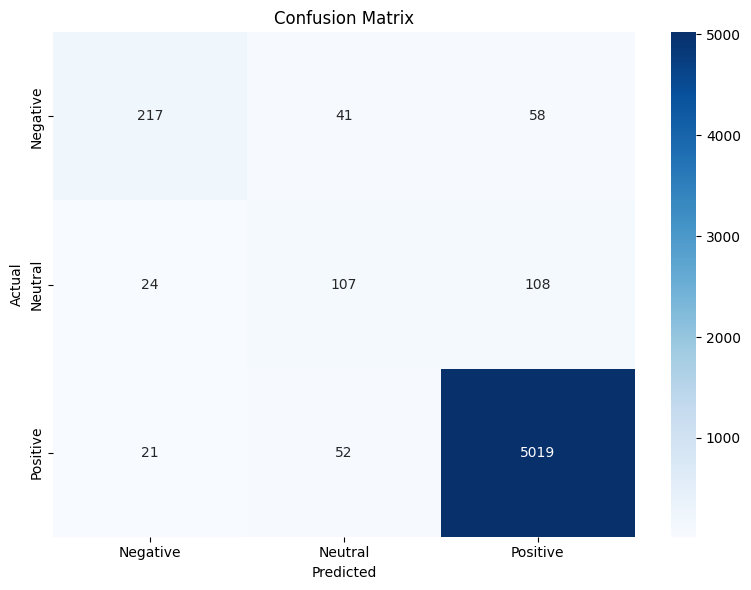

In [10]:
# Confusion matrix
cm = confusion_matrix(test_df['label'].values, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 2.8 Save Model

In [11]:
# Save the fine-tuned model and tokenizer
model.save_pretrained('models/sentiment_classifier')
tokenizer.save_pretrained('models/sentiment_classifier')
print("Model saved to models/sentiment_classifier/")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to models/sentiment_classifier/
